In [1]:
%matplotlib inline


# Compute MNE inverse solution on evoked data in a mixed source space


Create a mixed source space and compute MNE inverse solution on evoked dataset.


In [3]:
# Author: Annalisa Pascarella <a.pascarella@iac.cnr.it>
#
# License: BSD (3-clause)

import os.path as op
import matplotlib.pyplot as plt

# from nilearn import plotting

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse

# Set dir
data_path = mne.datasets.sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_mixed_src = op.join(bem_dir, '%s-oct-6-mixed-src.fif' % subject)
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')

fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)

fname_evoked = data_dir + '/sample_audvis-ave.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

Set up our source space.



In [4]:
# List substructures we are interested in. We select only the
# sub structures we want to include in the source space
labels_vol = ['Left-Amygdala',
              'Left-Thalamus-Proper',
              'Left-Cerebellum-Cortex',
              'Brain-Stem',
              'Right-Amygdala',
              'Right-Thalamus-Proper',
              'Right-Cerebellum-Cortex']

# Get a surface-based source space, here with few source points for speed
# in this demonstration, in general you should use oct6 spacing!
src = mne.setup_source_space(subject, spacing='oct5',
                             add_dist=False, subjects_dir=subjects_dir)

# Now we create a mixed src space by adding the volume regions specified in the
# list labels_vol. First, read the aseg file and the source space bounds
# using the inner skull surface (here using 10mm spacing to save time,
# we recommend something smaller like 5.0 in actual analyses):

vol_src = mne.setup_volume_source_space(
    subject, mri=fname_aseg, pos=10.0, bem=fname_model,
    volume_label=labels_vol, subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True)

# Generate the mixed source space
src += vol_src

# Visualize the source space.
src.plot(subjects_dir=subjects_dir)

n = sum(src[i]['nuse'] for i in range(len(src)))
print('the src space contains %d spaces and %d points' % (len(src), n))

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 1026/155407 selected to source space (oct = 5)

Loading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loade

Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
Reading /Users/DanielLongo 1/mne_data/MNE-sample-data/subjects/sample/mri/aseg.mgz...
the src space contains 9 spaces and 2169 points


We could write the mixed source space with::

   >>> write_source_spaces(fname_mixed_src, src, overwrite=True)

We can also export source positions to nift file and visualize it again:



In [5]:
nii_fname = op.join(bem_dir, '%s-mixed-src.nii' % subject)
src.export_volume(nii_fname, mri_resolution=True)

# plotting.plot_img(nii_fname, cmap='nipy_spectral')

# Compute the fwd matrix
fwd = mne.make_forward_solution(
    fname_evoked, fname_trans, src, fname_bem,
    mindist=5.0,  # ignore sources<=5mm from innerskull
    meg=True, eeg=False, n_jobs=1)

leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

src_fwd = fwd['src']
n = sum(src_fwd[i]['nuse'] for i in range(len(src_fwd)))
print('the fwd src space contains %d spaces and %d points' % (len(src_fwd), n))

# Load data
condition = 'Left Auditory'
evoked = mne.read_evokeds(fname_evoked, condition=condition,
                          baseline=(None, 0))
noise_cov = mne.read_cov(fname_cov)

# Compute inverse solution and for each epoch
snr = 3.0            # use smaller SNR for raw data
inv_method = 'dSPM'  # sLORETA, MNE, dSPM
parc = 'aparc'       # the parcellation to use, e.g., 'aparc' 'aparc.a2009s'

lambda2 = 1.0 / snr ** 2

# Compute inverse operator
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         depth=None, fixed=False)

stc = apply_inverse(evoked, inverse_operator, lambda2, inv_method,
                    pick_ori=None)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels_parc = mne.read_labels_from_annot(
    subject, parc=parc, subjects_dir=subjects_dir)

Reading FreeSurfer lookup table
Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=1026, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=1026, coordinate_frame=MRI (surface RAS)>, <volume (Left-Amygdala), n_used=2, coordinate_frame=MRI (surface RAS)>, <volume (Left-Thalamus-Proper), n_used=9, coordinate_frame=MRI (surface RAS)>, <volume (Left-Cerebellum-Cortex), n_used=33, coordinate_frame=MRI (surface RAS)>, <volume (Brain-Stem), n_used=21, coordinate_frame=MRI (surface RAS)>, <volume (Right-Amygdala), n_used=1, coordinate_frame=MRI (surface RAS)>, <volume (Right-Thalamus-Proper), n_used=7, coordinate_frame=MRI (surface RAS)>, <volume (Right-Cerebellum-Cortex), n_used=44, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : /Users/DanielLongo 1/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis-ave.fif
Conductor model   : /Users/DanielLongo 1/mne_data/MNE-sample-data

In [9]:
evoked.data.shape

(376, 421)

Average the source estimates within each label of the cortical parcellation
and each sub structure contained in the src space



Extracting time courses for 75 labels (mode: mean)


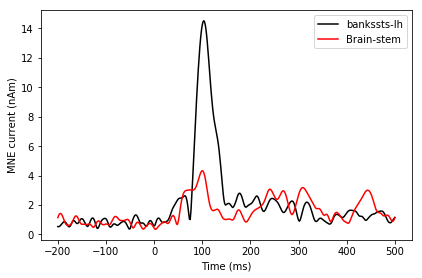

In [6]:
src = inverse_operator['src']

label_ts = mne.extract_label_time_course(
    [stc], labels_parc, src, mode='mean', allow_empty=True)

# plot the times series of 2 labels
fig, axes = plt.subplots(1)
axes.plot(1e3 * stc.times, label_ts[0][0, :], 'k', label='bankssts-lh')
axes.plot(1e3 * stc.times, label_ts[0][71, :].T, 'r', label='Brain-stem')
axes.set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
axes.legend()
mne.viz.tight_layout()